# Installing Randomer Forest (RerF)

In [14]:
# install R Randomer Forest package
# library(devtools)
# install_github("neurodata/R-RerF", subdir = "rerf")
library(rerf)

# Specify the data matrix X and class labels Y for training

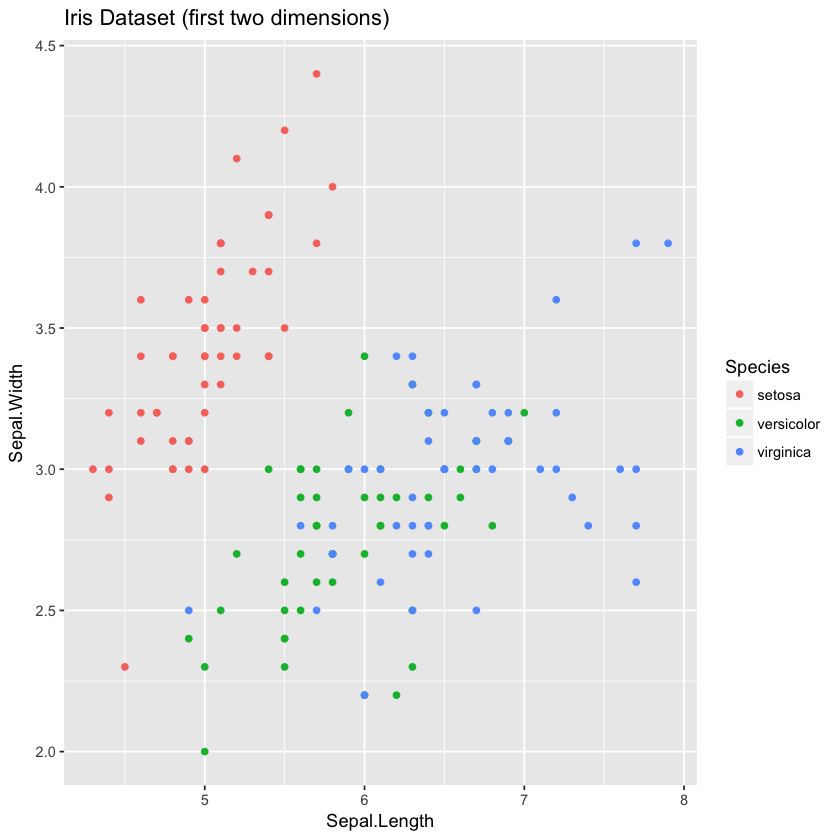

In [2]:
# we will use the iris dataset, which has 150 observations, 4 features, and 3 classes
X <- as.matrix(iris[1:4]) # can be dataframe, but a matrix is preferred
Y <- as.integer(iris[[5]]) # must be numeric (preferably integer) and between 1 and the number of classes
p <- ncol(X) # number of dimensions
num.class <- length(unique(Y)) # number of classes
seed <- 123L

library(ggplot2)

gghandle <- ggplot(data = iris, mapping = aes(Sepal.Length, Sepal.Width)) + geom_point(aes(colour = Species)) + 
                   ggtitle("Iris Dataset (first two dimensions)")
print(gghandle)

# Train a RerF Classifier

In [3]:
models <- vector(mode = "list", length = 2L)
# train a RerF classifier that samples one split projection per node
models[[1L]] <- RerF(X = X, Y = Y, num.class = num.class, trees = 500L, min.parent = 2L, max.depth = "inf",
               replacement = T, stratify = T, fun = RandMat, options = list(p, 1L, "binary", 1/p),
               store.oob = T, num.cores = 4L, seed = seed) 

# train a RerF classifier that samples 3 split projections per node
models[[2L]] <- RerF(X = X, Y = Y, num.class = num.class, trees = 500L, min.parent = 2L, max.depth = "inf",
               replacement = T, stratify = T, fun = RandMat, options = list(p, 4L, "binary", 1/p),
               store.oob = T, num.cores = 4L, seed = seed) 

# Select the better of the two models based on OOB error

In [4]:
oobError <- double(2L)

# compute oob error for first model
oobScores <- OOBPredict(X = X, forest = models[[1L]], num.cores = 4L) # scores/probabilities of being in each class
Yhats <- max.col(oobScores)
oobError[1L] <- mean(Yhats != Y)
print(paste0("model 1 OOB error rate: ", sprintf("%.2f", oobError[1L]*100), "%"), quote = F)

# compute oob error for second model
oobScores <- OOBPredict(X = X, forest = models[[2L]], num.cores = 4L)
Yhats <- max.col(oobScores)
oobError[2L] <- mean(Yhats != Y)
print(paste0("model 2 OOB error rate: ", sprintf("%.2f", oobError[2L]*100), "%"), quote = F)

# select the model that has the lower OOB error
bestModel <- which(oobError == min(oobError))
print(paste0("model ", bestModel, " is the better model"), quote = F)

[1] model 1 OOB error rate: 5.33%
[1] model 2 OOB error rate: 4.00%
[1] model 2 is the better model


# Compute error on a new set of observations

In [5]:
scores <- Predict(X = X, forest = models[[bestModel]], num.cores = 4L)
Yhats <- max.col(scores)
mcr <- mean(Yhats != Y)
print(paste0("error rate on test set: ", sprintf("%.2f", mcr*100), "%"), quote = F)

[1] error rate on test set: 0.00%


# Compute pairwise similarity between points

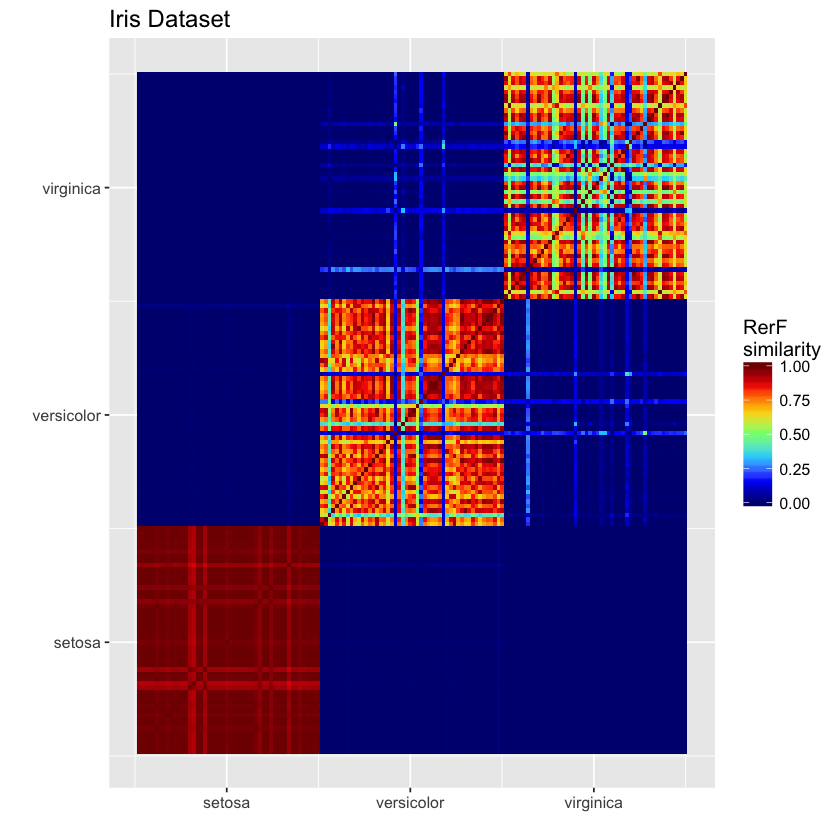

In [15]:
sim <- ComputeSimilarity(X = X, forest = models[[bestModel]], num.cores = 4L)

PlotSimilarity(mtx = sim, xlabel = "", ylabel = "", title = "Iris Dataset", include_diag = T,
               legend.name = "RerF\nsimilarity", xticks = c(25, 75, 125), yticks = c(25, 75, 125),
               xticklabels = c("25" = "setosa", "75" = "versicolor", "125" = "virginica"),
               yticklabels = c("25" = "setosa", "75" = "versicolor", "125" = "virginica"))

# Using RerF with categorical data

In [ ]:
# categorical features must be one-of-K binary encoded. the categorical features must come after the numeric features
X <- as.matrix(read.table("~/tmp/uci/processed/data/audiology_std.csv", header = F, sep = ",", quote = "", row.names = NULL))

# read in the csv file that specifies how the one-of-K encoded features are grouped together
catMap <- GetCatMap("~/tmp/uci/processed/categorical_map/audiology_std_catmap.txt")

# read in the csv file that specifies a 5-fold CV partition
fold <- GetFolds("~/tmp/uci/processed/cv_partitions/audiology_std_partitions.txt")

pcat <- length(catMap)
pnum <- catMap[[1L]][1L] - 1L
p <- pcat + pnum
p.ohe <- ncol(X) - 1L
Y <- as.integer(X[, p.ohe + 1L]) + 1L
X <- X[, -(p.ohe + 1L)]
nClasses <- length(unique(Y))

mtry <- ceiling(p^(1/2))
# mtry <- ceiling(p.ohe^(1/2))
nTrees <- 500L
stratify <- T
replacement <- T
randomMatrix <- "binary"
sparsity <- 1/p
rotate <- F
MinParent <- 2L
MaxDepth <- "inf"
COOB <- T
CNS <- F
NumCores <- 4L
comp.mode <- "batch"
rank.transform <- F
  
print("training", quote = F)
start.time <- proc.time()
oob.error <- double(length(fold))
test.error <- double(length(fold))

# start 5-fold cross-validation
for (k in seq.int(length(fold))) {
  train.idx <- unlist(fold[-k])
  test.idx <- fold[[k]]
  forest <- RerF(X[train.idx, ], Y[train.idx], nClasses, min.parent = MinParent, trees = nTrees, max.depth = MaxDepth, replacement = replacement,
                 stratify = stratify, fun = RandMatCat, options = list(p, mtry, randomMatrix, sparsity, catMap), store.oob = COOB,
                 store.ns = CNS, num.cores = NumCores, seed = 123L, rotate = rotate, rank.transform = rank.transform)
  train.time <- (proc.time() - start.time)[[3]]
  print("training complete", quote = F)
  cat(paste0("elapsed time: ", train.time, " sec\n"))
  
  # compute out-of-bag predictions
  print("computing OOB error", quote = F)
  scores <- OOBPredict(X[train.idx, ], forest, NumCores)
  oob.error[k] <- mean(max.col(scores) != Y[train.idx])
  print(paste0("OOB error rate: ", sprintf("%.2f", oob.error[k]*100), "%"), quote = F) 
  
  print("computing error on held out set", quote = F)
  scores <- Predict(X[test.idx, ], forest, NumCores)
  test.error[k] <- mean(max.col(scores) != Y[test.idx])
  print(paste0("CV error rate: ", sprintf("%.2f", test.error[k]*100), "%"), quote = F)
}
